# Library Import

In [9]:
import numpy as np
import pandas as pd 
import os

import matplotlib.pyplot as plt 
from sklearn.datasets import load_files

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

CUDA Available: True
GPU Name: NVIDIA GeForce GTX 1660 Ti with Max-Q Design


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Load 


In [12]:
# dir= "D:/Coding Projects/GitHub Projects/metal-surface-defect-classification/"

In [13]:
train_dir = 'D:/Coding Projects/GitHub Projects/metal-surface-defect-classification/data/raw/train'
print("Train Direcorty: ",os.listdir(train_dir))
test_dir = 'D:/Coding Projects/GitHub Projects/metal-surface-defect-classification/data/raw/test'
print("test Direcorty: ",os.listdir(test_dir))
val_dir = 'D:/Coding Projects/GitHub Projects/metal-surface-defect-classification/data/raw/valid'
print("val Direcorty: ",os.listdir(val_dir))

Train Direcorty:  ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']
test Direcorty:  ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']
val Direcorty:  ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']


# Custom Data Loader

In [27]:
import os
from torch.utils.data import Dataset
from PIL import Image

class MetalSurfaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        root_dir -> path to the train folder
        train/ 
            Crazing/
            Inclusion/
            ...
        """

        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {} # mapping class names to integers

        # Step 1 : Create class index mapping
        classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

        # Step 2 : iterate through each class folder
        for cls_name in classes:
            cls_folder = os.path.join(root_dir,cls_name)
            label = self.class_to_idx[cls_name]

            # Step 3 : Iterate thrugh each image in one class folder
            for file_name in sorted(os.listdir(cls_folder)):
                file_path = os.path.join(cls_folder, file_name)
                
                # Append image path and corresponding label
                self.image_paths.append(file_path)
                self.labels.append(label)
     
    def __len__(self):
        """ Return total count of images. """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Getting a sample image 
        """
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image
        img = Image.open(img_path).convert("RGB")

        # Apply transforms (resize, normalize, etc.)
        if self.transform:
            img = self.transform(img)

        return img, label

In [28]:
train_dataset = MetalSurfaceDataset(
    root_dir= train_dir,
    transform= None
)

val_dataset = MetalSurfaceDataset(
    root_dir= val_dir,
    transform= None
)

test_dataset = MetalSurfaceDataset(
    root_dir= test_dir,
    transform= None
)

In [ ]:
print(f"Total Number of Train Images : {train_dataset.__len__()}")
print(f"Total Number of Validation Images : {val_dataset.__len__()}")
print(f"Total Number of Test Images : {test_dataset.__len__()}")

Total Number of Train Images : 1656
Total Number of Validation Images : 72
Total Number of Test Images : 72


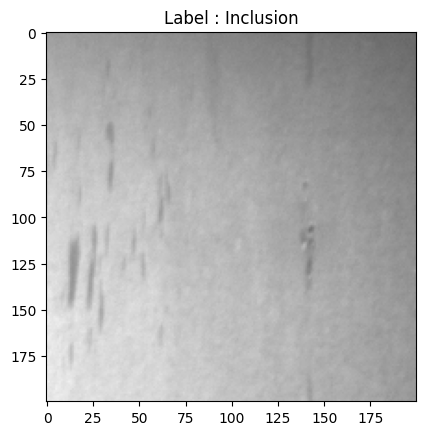

In [38]:
sample_number = 400

idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

image, label = train_dataset.__getitem__(sample_number)

plt.imshow(image)
plt.title(f"Label : {idx_to_class[label]}")
plt.show()


In [42]:
type(train_dataset.__getitem__(sample_number)[1])

int

# Data Preprocessing

In [ ]:
from torchvision import transforms

train_transform = transforms.Compose({
    tr
})

## Pre-processing the data

In [9]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(200, 200),
        batch_size=32,
        class_mode='categorical')

# Flow validation images in batches of 32 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(200, 200),
        batch_size=32,
        class_mode='categorical')

Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


# Model Training

In [10]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.98 ):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True 

Model definition

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.summary()

d:\Coding Projects\GitHub Projects\metal-surface-defect-classification\env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 199, 199, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 98, 98, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 49, 49, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,917,734 (72.17 MB)

 Trainable params: 18,917,734 (72.17 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print('Compiled!')

Compiled!


In [13]:
callbacks = myCallback()
history = model.fit(train_generator,
        batch_size = 32,
        epochs=20,
        validation_data=validation_generator,
        callbacks=[callbacks],
        verbose=1, shuffle=True)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.2228 - loss: 1.9363 - val_accuracy: 0.4722 - val_loss: 1.4947
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 44s 842ms/step - accuracy: 0.4088 - loss: 1.4552 - val_accuracy: 0.3750 - val_loss: 1.3995
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 43s 818ms/step - accuracy: 0.5115 - loss: 1.2685 - val_accuracy: 0.7083 - val_loss: 0.7957
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 43s 824ms/step - accuracy: 0.6153 - loss: 1.0344 - val_accuracy: 0.5694 - val_loss: 1.0872
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 43s 829ms/step - accuracy: 0.6721 - loss: 0.9223 - val_accuracy: 0.6667 - val_loss: 0.7498
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 43s 816ms/step - accuracy: 0.7337 - loss: 0.7863 - val_accuracy: 0.8750 - val_loss: 0.3840
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 43s 830ms/step - accuracy: 0.7566 - loss: 0.7089 - val_accuracy: 0.7917 - val_loss: 0.6818
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 46s 879ms/step - accuracy: 0.7905 - loss: 0.6401 - val_accurac

KeyboardInterrupt: 

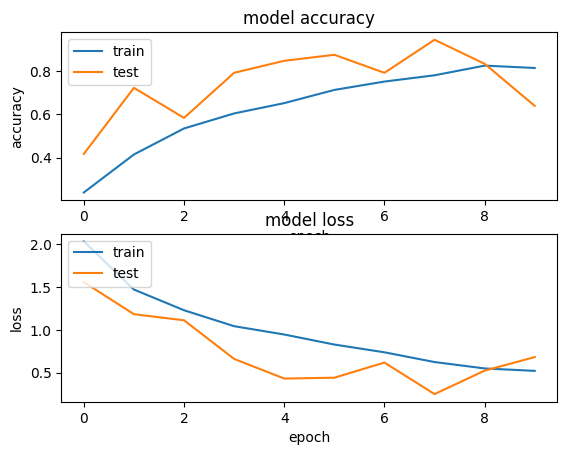

In [ ]:
plt.figure(1)  
# summarize history for accuracy  
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()


# Test Result visualization

In [ ]:
print(test_dir)

D:/Coding Projects/GitHub Projects/Metal Surface Defects Classifications/Metal-Surface-Defects-Classification/Dataset/test


In [40]:
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
    
x_test, y_test,target_labels = load_dataset(test_dir)

In [41]:
no_of_classes = len(np.unique(y_test))
no_of_classes

6

In [43]:
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_test, num_classes=no_of_classes)

In [44]:
# We just have the file names in the x set. Let's load the images and convert them into array.
from keras.preprocessing.image import array_to_img, img_to_array, load_img

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

Test set shape :  (72, 200, 200, 3)


In [45]:
x_test = x_test.astype('float32')/255

In [15]:
# Let's visualize test prediction.

y_pred = model.predict(x_test)

# plot a raandom sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

NameError: name 'model' is not defined